# Machine Learning and Deep NLP Classification of Reviews

* Use modeling piplines with the text vectorizer and model in the same pipline
* Use a Keras TextVectorization layer as part of an RNN model

## Tasks:
* Machine Learning
    * Create a text vectorizer
    * Build a machine learning model
    * GridSearch text vectorization
    * Save best model and train/test Data as Joblibs
* Deep NLP (RNNs)
    * Create train/test/val datasets
    * Create a Keras Text Vectorization Layer
    * Build an RNN with the TextVectorization Layer
    * Save best RNN model and Tensorflow Datasets

## Importing Libraries and Custom Functions

In [1]:
#load the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, optimizers, regularizers
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer, TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from pprint import pprint
import nltk
import joblib
import math
import os
import sys
import itertools
set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
tf.config.experimental.enable_op_determinism()
tf.config.set_visible_devices([], 'GPU')

In [2]:
#import custom function location
%load_ext autoreload
%autoreload 2
sys.path.append('../')
import custom_functions as fn

In [3]:
#import functions that cannot be used in custom_functions
#LSTM
def build_lstm_model(text_vectorization_layer):
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    # Add *new* LSTM layer
    lstm_model.add(layers.LSTM(128))
    # Add output layer
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    lstm_model.summary()
    return lstm_model

#call backs
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

#GRU
def build_gru_model(text_vectorization_layer):
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

#Bi-directional with GRU
def build_gru_model_bi_pool(text_vectorization_layer):
    
    gru_model_bi_pool = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=MAX_TOKENS,
                      output_dim=EMBED_DIM,
                      input_length=SEQUENCE_LENGTH)])
        
    # Add bidirectional component to GRU layer 
    gru_model_bi_pool.add(layers.Bidirectional(layers.GRU(128, return_sequences = True)))
    
    # Add a pooling layer *new
    gru_model_bi_pool.add(layers.GlobalMaxPooling1D())
    
    # Output layer
    gru_model_bi_pool.add(layers.Dense(len(classes), activation='softmax'))
                     
    optimizer = optimizers.legacy.Adam()
    gru_model_bi_pool.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model_bi_pool.summary()
    return gru_model_bi_pool

## Data Processing

In [4]:
#import the joblib data
df = joblib.load("Data-NLP/processed-data-no-html.joblib")
df

,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas,tokens-joined,lemmas-joined
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife,...",7.0,None,"[fine, piece, cinema, wong, kar, wai, tells, story, people, circumstance, throws, way, expect, start, couples, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leaves, increasingly, loos...","[fine, piece, cinema, Wong, Kar, Wai, tell, story, people, circumstance, throw, way, expect, start, couple, new, building, newspaper, man, wife, business, executive, wife, businessman, rarely, home, journalist, wife, leave, increasingly, loose, e...",fine piece cinema wong kar wai tells story people circumstance throws way expect start couples new building newspaper man wife business executive wife businessman rarely home journalist wife leaves increasingly loose ends long friendship develops...,fine piece cinema Wong Kar Wai tell story people circumstance throw way expect start couple new building newspaper man wife business executive wife businessman rarely home journalist wife leave increasingly loose end long friendship develop usual...
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love Great Escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I l...",6.0,None,"[roommate, hates, stop, motion, animation, watched, 2018, good, time, maybe, great, remember, thinking, little, kid, holds, degree, final, rating, liked, personally, recommend]","[roommate, hate, stop, motion, animation, watch, 2018, good, time, maybe, great, remember, think, little, kid, hold, degree, final, rating, like, personally, recommend]",roommate hates stop motion animation watched 2018 good time maybe great remember thinking little kid holds degree final rating liked personally recommend,roommate hate stop motion animation watch 2018 good time maybe great remember think little kid hold degree final rating like personally recommend
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with...",7.0,None,"[ok, huge, temptation, riddle, review, puns, going, cracking, little, family, adventure, seemingly, based, range, classic, movies, great, escape, star, trek, love, story, score, cannibalised, written, messrs., korngold, williams, bernstein, addin...","[ok, huge, temptation, riddle, review, pun, go, crack, littl

In [5]:
#ensure to drop any reviews that are not in rating category
df = df.dropna(subset=['rating_category'])
df

,review_id,movie_id,imdb_id,original_title,review,rating,rating_category,tokens,lemmas,tokens-joined,lemmas-joined
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,High,"[guilty, pleasure, personally, love, great, escape, works, seen, years, rightfully, esteemed, british, animation, company, highly, recommended, children, adults, enjoy, animation]","[guilty, pleasure, personally, love, Great, Escape, work, see, year, rightfully, esteem, british, animation, company, highly, recommend, child, adult, enjoy, animation]",guilty pleasure personally love great escape works seen years rightfully esteemed british animation company highly recommended children adults enjoy animation,guilty pleasure personally love Great Escape work see year rightfully esteem british animation company highly recommend child adult enjoy animation
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",3.0,Low,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, com...","[underwhelme, straight, bore, course, see, Hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, Australia, grab, attention, say, cause, pretty, biased, come, hear, tell...",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossi...,underwhelme straight bore course see Hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly Australia grab attention say cause pretty biased come hear tell mission Impossible II low poi...
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf...,2.0,Low,"[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, need, barf, bag, stand, slo, mo, seconds, 15, seconds, amazed, decide, push, m,...","[entertainign, Mission, Impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie...",entertainign mission impossible second installment turned terrible screenwriters know fill 2 hrs action overuse heroic slow motion scenes horrible need barf bag stand slo mo seconds 15 seconds amazed decide push m movies turned better hard beat l...,entertainign Mission Impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic slow motion scene horrible need barf bag stand slo mo second 15 second amazed decide push m movie turn well hard beat lousy piece ...
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings

## Machine Learning

In [6]:
#define X and Y
X = df['review']
y = df['rating_category']

In [7]:
#perform a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
#create a pipline with vectorizer and classification models
NB_pipe = Pipeline([('vectorizer', CountVectorizer()), ('clf', MultinomialNB())])
lg_pipe = Pipeline([('vectorizer', CountVectorizer()), ('clf', LogisticRegression())])

### Fit and evaluate each model

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.99      0.96      0.97       773
         Low       0.96      0.99      0.98       847

    accuracy                           0.97      1620
   macro avg       0.98      0.97      0.97      1620
weighted avg       0.97      0.97      0.97      1620



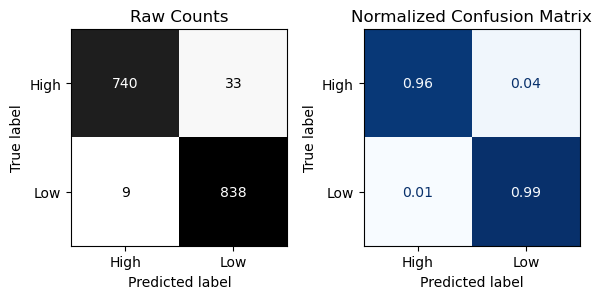


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.89      0.78      0.83       265
         Low       0.81      0.91      0.86       276

    accuracy                           0.84       541
   macro avg       0.85      0.84      0.84       541
weighted avg       0.85      0.84      0.84       541



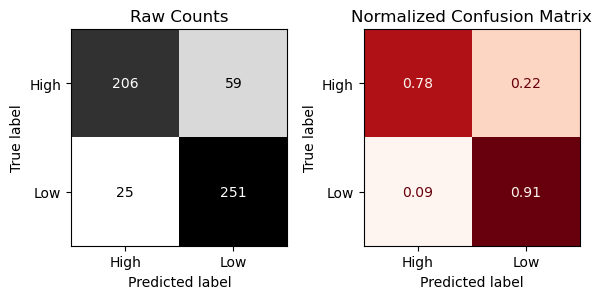

In [9]:
#MultinomialNB
NB_pipe.fit(X_train, y_train)
fn.evaluate_classification(NB_pipe, X_train, y_train, X_test, y_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       773
         Low       1.00      1.00      1.00       847

    accuracy                           1.00      1620
   macro avg       1.00      1.00      1.00      1620
weighted avg       1.00      1.00      1.00      1620



/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


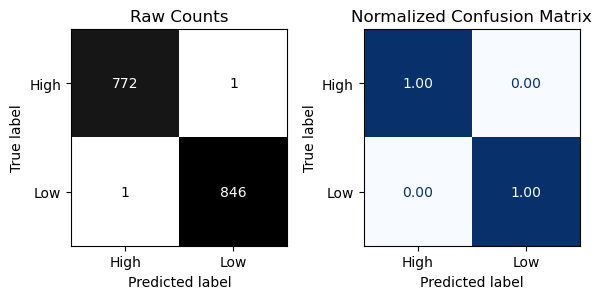


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.83      0.82      0.83       265
         Low       0.83      0.84      0.83       276

    accuracy                           0.83       541
   macro avg       0.83      0.83      0.83       541
weighted avg       0.83      0.83      0.83       541



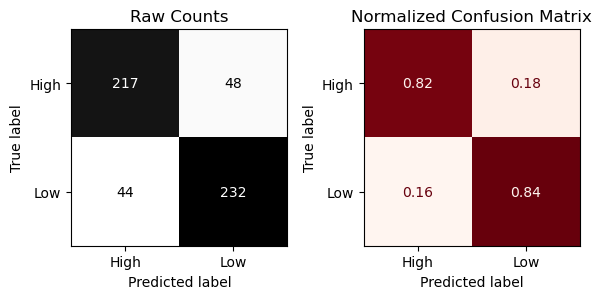

In [10]:
#LogisticRegression
lg_pipe.fit(X_train, y_train)
fn.evaluate_classification(lg_pipe, X_train, y_train, X_test, y_test)

Multinomial NB, with no parameters, did well in both the training and testing data. 
Logistic Regression, with no parameters, has overfitting in the training data and decent scores for the testing data. 

Multinomial NB: Training - 97%, Testing - 84%
Logistic Regression: Training - 100%, Testing - 83%

### GridSearch Text Vectorization

In [11]:
#define parameters for vectorizers
param_grid_shared = {
    "vectorizer__max_df": [0.7, 0.8, 0.9],
    'vectorizer__min_df': [ 2, 3, 4 ], 
    "vectorizer__max_features": [None, 1000, 2000],
    "vectorizer__stop_words": [None,'english'],
    "vectorizer__ngram_range":[(1,1),(1,2)]
}

#params for countVectorizer
param_grid_count = {
    'vectorizer':[CountVectorizer()],
    **param_grid_shared
}

#params for TfidfVectorizer
param_grid_tfidf = {
    'vectorizer': [TfidfVectorizer()],
    "vectorizer__norm": ["l1", "l2"],
    "vectorizer__use_idf": [True, False],
    **param_grid_shared
}

#combined params
vect_params_combined = [param_grid_count, param_grid_tfidf]

In [12]:
#define parameters for models
param_grid_MNB = {
    'clf' : [MultinomialNB()],
    'clf__alpha' : [.5, 1],
}

param_grid_logreg = {
    'clf': [LogisticRegression(random_state = 42, solver='lbfgs', max_iter=500)],
    'clf__C' : [.1, 1, 10, 100],
}

model_params_combined = [param_grid_MNB, param_grid_logreg]

In [13]:
#use iterpools to create all combinations of vectorizers
combined_params = list(itertools.product(vect_params_combined, model_params_combined))
combined_params[0]

({'vectorizer': [CountVectorizer()],
  'vectorizer__max_df': [0.7, 0.8, 0.9],
  'vectorizer__min_df': [2, 3, 4],
  'vectorizer__max_features': [None, 1000, 2000],
  'vectorizer__stop_words': [None, 'english'],
  'vectorizer__ngram_range': [(1, 1), (1, 2)]},
 {'clf': [MultinomialNB()], 'clf__alpha': [0.5, 1]})

In [14]:
#use loop to combine the parameter grids for each combination
final_params = []
for vector_params, model_params in combined_params:
    combined = {**vector_params, **model_params}
    final_params.append(combined)
final_params[0]

{'vectorizer': [CountVectorizer()],
 'vectorizer__max_df': [0.7, 0.8, 0.9],
 'vectorizer__min_df': [2, 3, 4],
 'vectorizer__max_features': [None, 1000, 2000],
 'vectorizer__stop_words': [None, 'english'],
 'vectorizer__ngram_range': [(1, 1), (1, 2)],
 'clf': [MultinomialNB()],
 'clf__alpha': [0.5, 1]}

In [15]:
%%time
#combine the best model using GridSearchCV
grid_search = GridSearchCV(NB_pipe, final_params, cv=3, scoring='accuracy', 
                          verbose=1, n_jobs=-1)
#fit the model
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3240 candidates, totalling 9720 fits
CPU times: user 26.5 s, sys: 13.8 s, total: 40.3 s
Wall time: 5min 32s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf': [MultinomialNB()], 'clf__alpha': [0.5, 1],
                          'vectorizer': [CountVectorizer()],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__ngram_range': [(1, 1), (1, 2)...
                          'vectorizer': [TfidfVectorizer(max_df=0.7, min_df=3,
                                                         ngram_range=(1, 2))],
                          'vectorizer__max_df': [0.7, 0.8, 0.9],
                          'vectorizer__max_features': [None, 1000, 2000],
                          'vectorizer__min_df': [2, 3, 4],
                          'vectorizer__ngram_range': [(1, 1), (1, 2)],
                          'vectorizer__norm': ['l1', 'l2'],
                          'vectorizer__stop_words': [None, 'english'],
                          'vectorizer__use_idf': [True, False]}],
             scoring='accuracy', verbose=1)

In [16]:
#determine best combination
grid_search.best_params_

{'clf': LogisticRegression(C=100, max_iter=500, random_state=42),
 'clf__C': 100,
 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=3, ngram_range=(1, 2)),
 'vectorizer__max_df': 0.7,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 3,
 'vectorizer__ngram_range': (1, 2),
 'vectorizer__norm': 'l2',
 'vectorizer__stop_words': None,
 'vectorizer__use_idf': True}

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       773
         Low       1.00      1.00      1.00       847

    accuracy                           1.00      1620
   macro avg       1.00      1.00      1.00      1620
weighted avg       1.00      1.00      1.00      1620



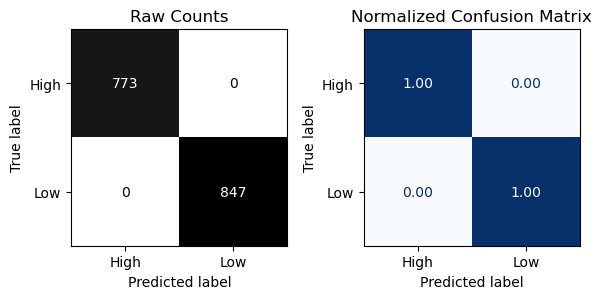


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

        High       0.87      0.86      0.87       265
         Low       0.87      0.88      0.87       276

    accuracy                           0.87       541
   macro avg       0.87      0.87      0.87       541
weighted avg       0.87      0.87      0.87       541



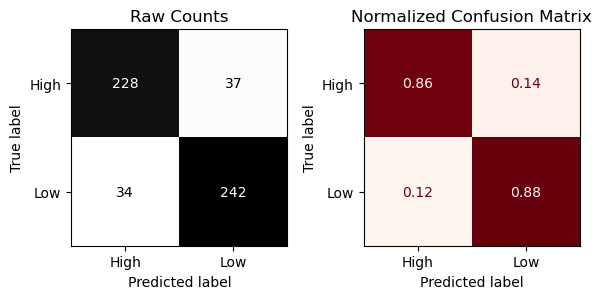

In [17]:
#evaluate best model
best_model = grid_search.best_estimator_
fn.evaluate_classification(best_model, X_train, y_train, X_test, y_test)

The best parameter, being LogisticRegression, had a training score of 100%, which can indicate overfitting, and a testing score of 87%.

### Save the Best Model and Train/Test Data as Joblibs

In [18]:
# Save training data
fpath_train_data = "Data-NLP/ml/train-data.joblib"
joblib.dump([X_train, y_train],fpath_train_data)
    
# Save test data
fpath_test_data = "Data-NLP/ml/test-data.joblib"
joblib.dump([X_test, y_test],fpath_test_data)
    
# Saving the best model 
fpath_best_ml_model  = "Models/ml/best-ml-logreg-model.joblib"
joblib.dump(best_model, fpath_best_ml_model)

['Models/ml/best-ml-logreg-model.joblib']

## Deep NLP (RNNs)

### Create train/test/val datasets

In [19]:
#define X and y and convert rating_category to integers
X = df['review']
y = pd.Series(LabelEncoder().fit_transform(df['rating_category']))
y.value_counts()

1    1123
0    1038
dtype: int64

In [20]:
classes = y.unique()
classes

array([0, 1])

In [21]:
#Create data into dataset object and shuffle the dataset
ds = tf.data.Dataset.from_tensor_slices((X,y))
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [22]:
#train test and split with .7, .2, 1 ratio
split_train = 0.7
n_train_samples = int(len(ds)*split_train)
split_val = 0.2
n_val_samples = int(len(ds)*split_val)
split_test = 1-(split_train + split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

#determine batch sizes
BATCH_SIZE = 32
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)
print(f"Training: {n_train_samples} samples ({n_train_batches} batches)")
print(f"Validation: {n_val_samples} samples ({n_val_batches} batches)")
print(f"Testing: {n_test_samples} samples ({n_test_batches} batches)")

Training: 1512 samples (48 batches)
Validation: 432 samples (14 batches)
Testing: 217 samples (7 batches)


In [23]:
#use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)
# Confirm the number of batches in each
print (f'{len(train_ds)} training batches.')
print (f'{len(val_ds)} validation batches.')
print (f'{len(test_ds)} testing batches.')

48 training batches.
14 validation batches.
7 testing batches.


### Create a Keras Text Vectorization Layer

In [24]:
#create the textvectorization layer
SEQUENCE_LENGTH = 500
sequence_vectorizer = tf.keras.layers.TextVectorization(
     standardize = "lower_and_strip_punctuation",
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

In [25]:
#obtain just the etxt component of the dataset
ds_texts = train_ds.map(lambda x, y: x)

In [26]:
#fit/adapt the text vectorization layer on the training text
sequence_vectorizer.adapt(ds_texts)

2023-12-07 23:14:28.952074: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [27]:
#save the vocab size
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

23957

### Build an RNN with the TextVectorization Layer

#### LSTM

In [28]:
#define embedding_dim
EMBED_DIM = 150

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 150)          3593550   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 3,736,656
Trainable params: 3,736,656
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
48/48 [==============================] - 18s 358ms/step - loss: 0.6939 - accuracy: 0.5423 - val_loss:

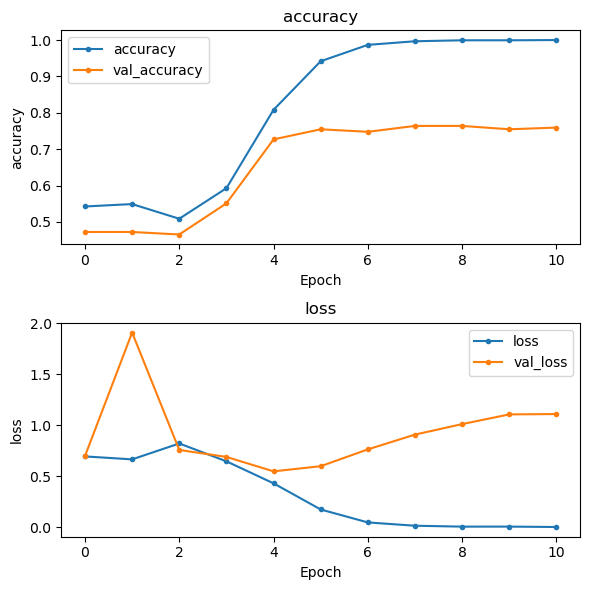


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       739
           1       1.00      1.00      1.00       773

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



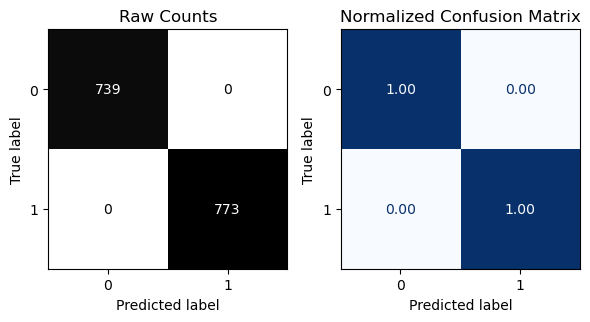


- Evaluating Training Data:
48/48 [==============================] - 4s 81ms/step - loss: 0.0013 - accuracy: 1.0000
{'loss': 0.0013188497396185994, 'accuracy': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.77      0.78        95
           1       0.82      0.84      0.83       122

    accuracy                           0.81       217
   macro avg       0.80      0.80      0.80       217
weighted avg       0.81      0.81      0.81       217



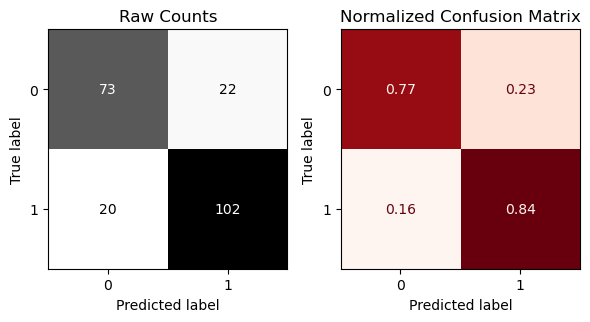


- Evaluating Test Data:
7/7 [==============================] - 1s 86ms/step - loss: 0.8840 - accuracy: 0.8065
{'loss': 0.8839547038078308, 'accuracy': 0.8064516186714172}


In [29]:
#use the custom function to build an LSTM model
lstm_model = build_lstm_model(sequence_vectorizer)
history = lstm_model.fit(train_ds, epochs=30, validation_data=val_ds,
                        callbacks=get_callbacks())
results = fn.evaluate_classification_network(lstm_model, X_train=train_ds,
                                            X_test=test_ds, history=history)

#### Gru Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 500, 150)          3593550   
                                                                 
 gru (GRU)                   (None, 500, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 3,701,328
Trainable params: 3,701,328
No

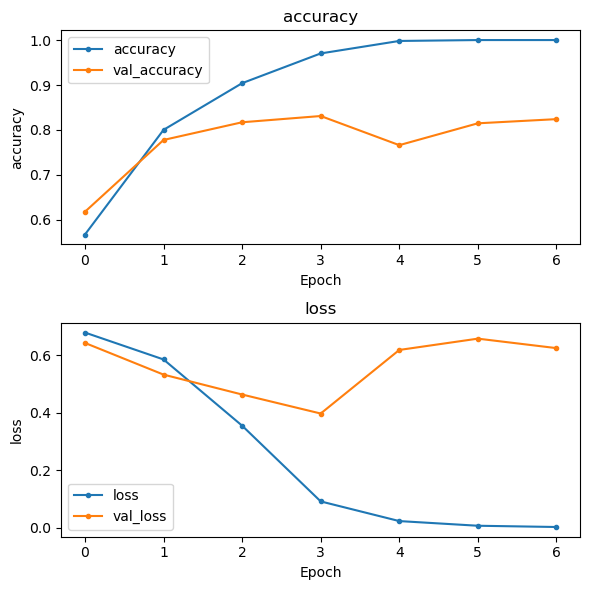


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       739
           1       1.00      1.00      1.00       773

    accuracy                           1.00      1512
   macro avg       1.00      1.00      1.00      1512
weighted avg       1.00      1.00      1.00      1512



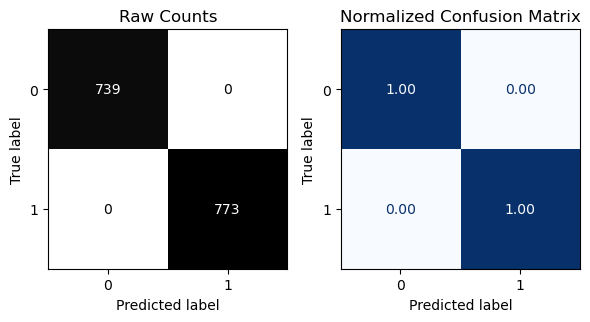


- Evaluating Training Data:
48/48 [==============================] - 5s 95ms/step - loss: 0.0021 - accuracy: 1.0000
{'loss': 0.0020897225476801395, 'accuracy': 1.0}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        95
           1       0.87      0.82      0.84       122

    accuracy                           0.83       217
   macro avg       0.83      0.83      0.83       217
weighted avg       0.83      0.83      0.83       217



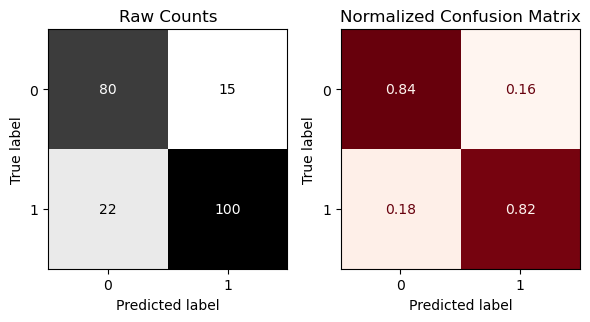


- Evaluating Test Data:
7/7 [==============================] - 1s 73ms/step - loss: 0.5374 - accuracy: 0.8295
{'loss': 0.5374307036399841, 'accuracy': 0.8294931054115295}


In [30]:
#use custom function to build gru model
gru_model = build_gru_model(sequence_vectorizer)
history = gru_model.fit(train_ds, epochs=30, validation_data=val_ds,
                       callbacks=get_callbacks())
results = fn.evaluate_classification_network(gru_model, X_train=train_ds,
                                            X_test=test_ds, history=history)

#### Bi-Directional

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 500, 150)          3593550   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 256)         215040    
 l)                                                              
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                      

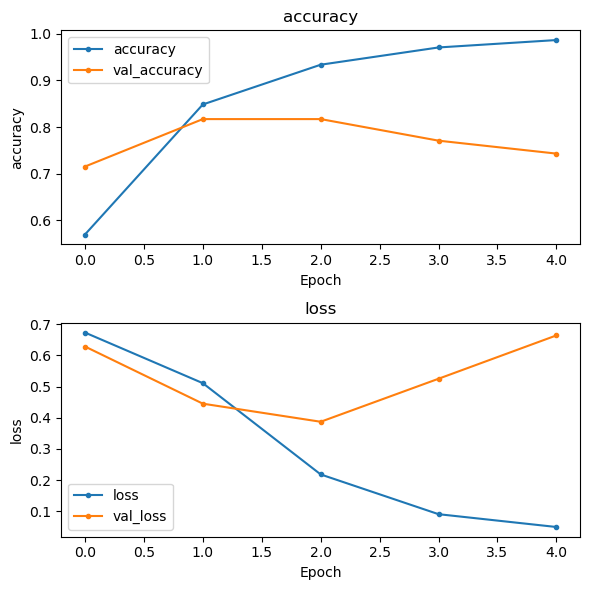


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       739
           1       1.00      0.98      0.99       773

    accuracy                           0.99      1512
   macro avg       0.99      0.99      0.99      1512
weighted avg       0.99      0.99      0.99      1512



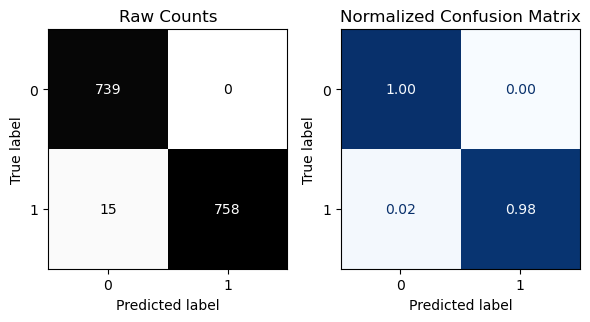


- Evaluating Training Data:
48/48 [==============================] - 4s 91ms/step - loss: 0.0515 - accuracy: 0.9901
{'loss': 0.05148913338780403, 'accuracy': 0.9900793433189392}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.95      0.77        95
           1       0.94      0.60      0.73       122

    accuracy                           0.75       217
   macro avg       0.79      0.77      0.75       217
weighted avg       0.81      0.75      0.75       217



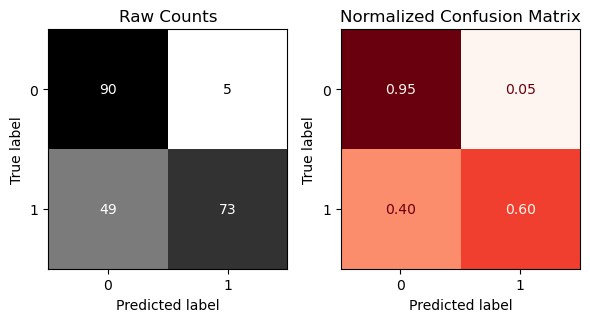


- Evaluating Test Data:
7/7 [==============================] - 1s 88ms/step - loss: 0.6961 - accuracy: 0.7512
{'loss': 0.6960643529891968, 'accuracy': 0.7511520981788635}


In [31]:
#use custom function to build bidirectional model
MAX_TOKENS = VOCAB_SIZE
bipool_model = build_gru_model_bi_pool(sequence_vectorizer)
history = bipool_model.fit(train_ds, epochs=30, validation_data=val_ds,
                          callbacks=get_callbacks())
results = fn.evaluate_classification_network(bipool_model, X_train=train_ds,
                                            X_test=test_ds, history=history)

Based on the models above, the GRU RNN model was the best Deep NLP. Its training score was at 100%, which could indicate overfitting, and its testing score was at 83%. 

The ML model performed slightly better than the RNN model by a difference in accuracy of 4%.

### Save the Best RNN model and Tenseflow Datasets

In [32]:
# Save the model in tf format 
fpath_model = "Models/nn/gru/"
gru_model.save(fpath_model, save_format='tf')

INFO:tensorflow:Assets written to: Models/nn/gru/assets


INFO:tensorflow:Assets written to: Models/nn/gru/assets


In [33]:
#save the training dataset object
fpath_train = "Data-NLP/nn/train/"
train_ds.save(path = fpath_train)

In [34]:
#save the testing dataset object
fpath_test = "Data-NLP/nn/test/"
test_ds.save(path=fpath_test)